# Capsule Network Implementation

 Experiment with Transfer Learning

Author: Gyanendar Manohar

Date: 21/03/2022

Referance:

* Code adapted from https://github.com/XifengGuo/CapsNet-Keras/blob/master/capsulenet.py

* Author: Xifeng Guo, E-mail: guoxifeng1990@163.com, Github: https://github.com/XifengGuo/CapsNet-Keras

Details:

Architure similar to present in the original paper for MINST dataset

32 Primary Capusle, 16 dimension output vector


The decoder part is acts as regularizer which prevent overfitting during training of the newtork. 

There is no decoder part here which has been removed to make training faster.

Loss of capsule network is margin loss + alpha * reconsutruction loss
As decoder network is not present, only margin loss is considered

# Headers

In [1]:
import os
import random
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import tensorflow.keras.backend as K
from tensorflow.keras import initializers, layers
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split



print(tf.__version__)

Using TensorFlow backend.


2.7.0


# Set Seed

In [2]:
#Set Seed for random number generation
def set_seed(seed = 100):
  tf.random.set_seed(seed)
  np.random.seed(seed)
  random.seed(seed)

In [3]:
import gc
gc.collect()

43

In [4]:
!nvidia-smi

Tue Mar 22 23:04:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 496.13       Driver Version: 496.13       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro T2000 wi... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   70C    P8     7W /  N/A |    132MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# CapsNet

In [5]:
class Length(layers.Layer):
    """
    Compute the length of vectors. This is used to compute a Tensor that has the same shape with y_true in margin_loss.
    Using this layer as model's output can directly predict labels by using `y_pred = np.argmax(model.predict(x), 1)`
    inputs: shape=[None, num_vectors, dim_vector]
    output: shape=[None, num_vectors]
    """
    def call(self, inputs, **kwargs):
        return tf.sqrt(tf.reduce_sum(tf.square(inputs), -1) + K.epsilon())

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

    def get_config(self):
        config = super(Length, self).get_config()
        return config


def squash(vectors, axis=-1):
    """
    Vector length is treated as probability which should lies between 0 and 1. This
    function brings the vector length in the range of 0 and 1
    @param vectors: vectors to be squashed, N-dim tensor
    @param axis: the axis to squash
    @return: a Tensor with same shape as input vectors
    """
    s_squared_norm = tf.reduce_sum(tf.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / tf.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors


class CapsuleLayer(layers.Layer):
    """
    The capsule layer. It is similar to Dense layer. Dense layer has `in_num` inputs, each is a scalar, the output of the
    neuron from the former layer, and it has `out_num` output neurons. CapsuleLayer just expand the output of the neuron
    from scalar to vector. So its input shape = [None, input_num_capsule, input_dim_capsule] and output shape = \
    [None, num_capsule, dim_capsule]. For Dense Layer, input_dim_capsule = dim_capsule = 1.
    @param num_capsule: number of capsules in this layer
    @param dim_capsule: dimension of the output vectors of the capsules in this layer
    @param routings: number of iterations for the routing algorithm
    """
    def __init__(self, num_capsule, dim_capsule, routings=3,
                 kernel_initializer='glorot_uniform',
                 **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.kernel_initializer = initializers.get(kernel_initializer)

    def build(self, input_shape):
        assert len(input_shape) >= 3, "The input Tensor should have shape=[None, input_num_capsule, input_dim_capsule]"
        self.input_num_capsule = input_shape[1]
        self.input_dim_capsule = input_shape[2]

        # Transform matrix, from each input capsule to each output capsule, there's a unique weight as in Dense layer.
        self.W = self.add_weight(shape=[self.num_capsule, self.input_num_capsule,
                                        self.dim_capsule, self.input_dim_capsule],
                                 initializer=self.kernel_initializer,
                                 name='W')

        self.built = True

    def call(self, inputs, training=None):
        # inputs.shape=[None, input_num_capsule, input_dim_capsule]
        # inputs_expand.shape=[None, 1, input_num_capsule, input_dim_capsule, 1]
        inputs_expand = tf.expand_dims(tf.expand_dims(inputs, 1), -1)

        # Replicate num_capsule dimension to prepare being multiplied by W
        # inputs_tiled.shape=[None, num_capsule, input_num_capsule, input_dim_capsule, 1]
        inputs_tiled = tf.tile(inputs_expand, [1, self.num_capsule, 1, 1, 1])

        # Compute `inputs * W` by scanning inputs_tiled on dimension 0.
        # W.shape=[num_capsule, input_num_capsule, dim_capsule, input_dim_capsule]
        # x.shape=[num_capsule, input_num_capsule, input_dim_capsule, 1]
        # Regard the first two dimensions as `batch` dimension, then
        # matmul(W, x): [..., dim_capsule, input_dim_capsule] x [..., input_dim_capsule, 1] -> [..., dim_capsule, 1].
        # inputs_hat.shape = [None, num_capsule, input_num_capsule, dim_capsule]
        inputs_hat = tf.squeeze(tf.map_fn(lambda x: tf.matmul(self.W, x), elems=inputs_tiled))

        # Begin: Routing algorithm ---------------------------------------------------------------------#
        # The prior for coupling coefficient, initialized as zeros.
        # b.shape = [None, self.num_capsule, 1, self.input_num_capsule].
        b = tf.zeros(shape=[inputs.shape[0], self.num_capsule, 1, self.input_num_capsule])

        assert self.routings > 0, 'The routings should be > 0.'
        for i in range(self.routings):
            # c.shape=[batch_size, num_capsule, 1, input_num_capsule]
            c = tf.nn.softmax(b, axis=1)

            # c.shape = [batch_size, num_capsule, 1, input_num_capsule]
            # inputs_hat.shape=[None, num_capsule, input_num_capsule, dim_capsule]
            # The first two dimensions as `batch` dimension,
            # then matmal: [..., 1, input_num_capsule] x [..., input_num_capsule, dim_capsule] -> [..., 1, dim_capsule].
            # outputs.shape=[None, num_capsule, 1, dim_capsule]
            outputs = squash(tf.matmul(c, inputs_hat))  # [None, 10, 1, 16]

            if i < self.routings - 1:
                # outputs.shape =  [None, num_capsule, 1, dim_capsule]
                # inputs_hat.shape=[None, num_capsule, input_num_capsule, dim_capsule]
                # The first two dimensions as `batch` dimension, then
                # matmal:[..., 1, dim_capsule] x [..., input_num_capsule, dim_capsule]^T -> [..., 1, input_num_capsule].
                # b.shape=[batch_size, num_capsule, 1, input_num_capsule]
                b += tf.matmul(outputs, inputs_hat, transpose_b=True)
        # End: Routing algorithm -----------------------------------------------------------------------#

        return tf.squeeze(outputs)

    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsule, self.dim_capsule])

    def get_config(self):
        config = {
            'num_capsule': self.num_capsule,
            'dim_capsule': self.dim_capsule,
            'routings': self.routings
        }
        base_config = super(CapsuleLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


def PrimaryCap(inputs, dim_capsule, n_channels, kernel_size, strides, padding):
    """
    Apply Conv2D `n_channels` times and concatenate all capsules
    @param inputs: 4D tensor, shape=[None, width, height, channels]
    @param dim_capsule: the dim of the output vector of capsule
    @param n_channels: the number of types of capsules
    @return: output tensor, shape=[None, num_capsule, dim_capsule]
    """
    output = layers.Conv2D(filters = dim_capsule*n_channels, 
                           kernel_size = kernel_size, 
                           strides = strides, 
                           padding = padding,
                           name='primarycap_conv2d')(inputs)
    outputs = layers.Reshape(target_shape = [-1, dim_capsule], 
                             name = 'primarycap_reshape')(output)
                             
    return layers.Lambda(squash, name='primarycap_squash')(outputs)

In [6]:
K.set_image_data_format('channels_last')

In [7]:
class CapsuleNet:
  @staticmethod
  def build(input_shape,number_of_class,routing_count,batch_size,model_name,
            dim_capsule=16,train_half_model = True):
    
   

   #@param input_shape: data shape, 3d, [width, height, channels]
   #@param number_of_class: number of classes
   #@param routing_count: number of routing iterations
   #@param batch_size: size of batch
  
   input = layers.Input(shape=input_shape, batch_size=batch_size)  

   high_level_model = get_high_level_model(model_name,input_tn=input)
   layers_count = len(high_level_model.layers)
   for index in range(layers_count):
      high_level_model.layers[index].trainable = False
      if train_half_model == True and index> int(layers_count//2):      
         high_level_model.layers[index].trainable = True  
      
   conv_1 = layers.Reshape(target_shape=[-1, dim_capsule], name='primarycap_reshape')(high_level_model.output)
   primary_capsule = layers.Lambda(squash, name='primarycap_squash')(conv_1)
   
   digitcaps = CapsuleLayer(num_capsule=number_of_class, 
                             dim_capsule=dim_capsule, 
                             routings=routing_count, 
                             name='digitcaps')(primary_capsule)    
   
   out_caps = Length(name='capsnet')(digitcaps)
   train_model = models.Model(input,outputs=out_caps)
   
   return train_model

In [ ]:
input = layers.Input(shape=(224,224,3), batch_size=32)
VGG16_model = tf.keras.applications.InceptionV3(weights='imagenet', \
                              include_top = False, input_tensor= input)
layers_count = len(VGG16_model.layers)
for index in range(layers_count):
    if(index> int(layers_count//2)):
        VGG16_model.layers[index].trainable = True  
    print(VGG16_model.layers[index].name)
#for layer in VGG16_model.layers:
#    print(layer.name)
    

In [8]:
def margin_loss(y_true, y_pred):
    
    L = y_true * tf.square(tf.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * tf.square(tf.maximum(0., y_pred - 0.1))
    return tf.reduce_mean(tf.reduce_sum(L, 1))

# High Level Model

In [9]:
# Returns Pretrained Network with top layer removed
# And Trainable set to false

def get_high_level_model(trained_model_name,input_tn):
  set_seed()
  model = None
  if trained_model_name == "vgg16":
      model = tf.keras.applications.VGG16(weights='imagenet', \
                              include_top = False, input_tensor = input_tn)
      
  elif trained_model_name == "vgg19":
      model =  tf.keras.applications.VGG19(weights='imagenet', \
                              include_top = False, input_tensor = input_tn)
      
  elif trained_model_name == "resnet50":
     model = tf.keras.applications.ResNet50(weights='imagenet', \
                              include_top = False, input_tensor = input_tn)
     
  elif trained_model_name == "densenet121":
     model = tf.keras.applications.DenseNet121(weights='imagenet', \
                            include_top = False, input_tensor = input_tn)
     
  elif trained_model_name == "densenet169":
     model = tf.keras.applications.DenseNet169(weights='imagenet', \
                            include_top = False, input_tensor = input_tn)

  elif trained_model_name == "InceptionV3":
     model = tf.keras.applications.InceptionV3(weights='imagenet', \
                            include_top = False, input_tensor = input_tn)

  elif trained_model_name == "MobileNet":
     model = tf.keras.applications.MobileNet(weights='imagenet', \
                            include_top = False, input_tensor = input_tn)                            
  
  return model

# Transfer Learning Without CapsNet Head

# Train

In [10]:
# Train Capsule Network
@tf.autograph.experimental.do_not_convert
def train(model, data, args):
    """
    Training a CapsuleNet
    @param model: the CapsuleNet model
    @param data: a tuple containing training and testing data, like `((x_train, y_train), (x_test, y_test))`
    @param args: arguments
    return: The trained model
    """
    # unpacking the data
    (x_train, y_train), (x_test, y_test) = data

    # callbacks to save the best model   
    checkpoint = callbacks.ModelCheckpoint(args.save_dir + '/weights.h5', monitor='val_accuracy',
                                           save_best_only=True, save_weights_only=True, verbose=1)  
    # Early Stopping, if accurcay not imporving for 25 epoch, stop the training
    early_stopping =  callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, \
                       patience=40)

    # compile the model
    model.compile(optimizer=optimizers.Adam(lr=args.lr),
                  loss=[margin_loss, 'mse'],
                  loss_weights=[1., args.lam_recon],run_eagerly=True,
                  metrics={'capsnet': 'accuracy'})

    # Train the model
    train_image_generator = ImageDataGenerator()  
    train_data_generator = train_image_generator.flow(x_train, y_train, batch_size=args.batch_size)
    val_image_generator = ImageDataGenerator()
    val_data_generator = val_image_generator.flow(x_test,y_test,batch_size = args.batch_size)
   
    history = model.fit(train_data_generator,
              steps_per_epoch=int(y_train.shape[0] / args.batch_size),
              epochs=args.epochs,verbose=0,              
              validation_data=val_data_generator, batch_size=args.batch_size,
              callbacks=[checkpoint,early_stopping])
 
    index = history.history["val_accuracy"].index(max(history.history["val_accuracy"]))
    best_val_accuracy = history.history["val_accuracy"][index]    
    print(f"Best Validation Accuracy:{best_val_accuracy}") 
    plot_model_performance(history)
   
    return model

# Plot Model Performance

In [11]:
from matplotlib import pyplot as plt
def plot_model_performance(history):
  plt.style.use("ggplot")
  plt.figure(figsize=(7,6))
  epoch_ran = len(history.history["loss"])
  plt.plot(np.arange(0, epoch_ran), \
           history.history["loss"], label="train_loss")
  plt.plot(np.arange(0, epoch_ran), \
           history.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, epoch_ran), \
           history.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, epoch_ran), \
           history.history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()
  plt.show()

# Train and Test The Model

In [12]:
@tf.autograph.experimental.do_not_convert
def get_model_train_test(data,args,high_level_model_name,train_half_model=True,
                                      dim_capsule=16,
                                   ):
  set_seed()
  (x_train,y_train),(x_test,y_test) = data
  # Build the model

  model = CapsuleNet.build(input_shape=x_train.shape[1:], 
                                      number_of_class=len(np.unique(np.argmax(y_train, 1))),
                                      routing_count=args.routings,
                                      batch_size=args.batch_size,                                      
                                      dim_capsule = dim_capsule,
                                      train_half_model = train_half_model,                                      
                                      model_name = high_level_model_name,
                                      )

  model.summary()
  # Train the model
  trained_model = train(model=model, data=((x_train, y_train), (x_test, y_test)), args=args)
  #Load the weight where accuracy was maximum
  trained_model.load_weights(f'./result/weights.h5')
  # Model Training Done
  #Prediction and calculate the matrix value
 
  y_pred= trained_model.predict(x_test,batch_size=x_test.shape[0])
  
  print("*******Model Performance*************")
  print('Test acc:', np.sum(np.argmax(y_pred, 1) == np.argmax(y_test, 1)) / y_test.shape[0])  

 
  result_pred = np.argmax(y_pred, axis=1) 
  result_actual = np.argmax(y_test, axis=1) 
  precision = precision_score(result_actual, result_pred)
  recall = recall_score(result_actual, result_pred)
  f1 = f1_score(result_actual, result_pred)
  tn, fp, fn, tp = confusion_matrix(result_actual, result_pred).ravel()
  fpr, tpr, thresholds = metrics.roc_curve(result_actual, result_pred)
  auc = metrics.auc(fpr, tpr)
  
  print(f"Precision:{precision}")
  print(f"recall:{recall}")
  print(f"f1:{f1}")
  print(f"AUC:{auc}")
  print(f"Sensitivity:{tp/(tp+fn)}")
  print(f"specificity:{tn/(tn+fp)}")

# Arguments

In [13]:
import argparse
import os
def get_arguments():
    parser = argparse.ArgumentParser(description="Capsule Network Glaucoma Classification.")
    parser.add_argument('--epochs', default=15, type=int)
    parser.add_argument('--batch_size', default=32, type=int)
    parser.add_argument('--lr', default=0.0001, type=float,
                            help="Initial learning rate")
    parser.add_argument('--lr_decay', default=1, type=float,
                        help="The value multiplied by lr at each epoch. Set a larger value for larger epochs")
    parser.add_argument('--lam_recon', default=0.392, type=float,
                        help="The coefficient for the loss of decoder")
    parser.add_argument('-r', '--routings', default=1, type=int,
                        help="Number of iterations used in routing algorithm. should > 0")
    parser.add_argument('--shift_fraction', default=0.1, type=float,
                        help="Fraction of pixels to shift at most in each direction.")
    parser.add_argument('--debug', action='store_true',
                        help="Save weights by TensorBoard")
    parser.add_argument('--save_dir', default='./result')
    parser.add_argument('--augmentation', default=False, type=bool)
    parser.add_argument('-t', '--testing', action='store_true',
                        help="Test the trained model on testing dataset")
    parser.add_argument('--digit', default=5, type=int,
                        help="Digit to manipulate")
    parser.add_argument('-w', '--weights', default=None,
                        help="The path of the saved weights. Should be specified when testing")
    args, unknown = parser.parse_known_args()
    print(args)

    if not os.path.exists(args.save_dir):
        os.makedirs(args.save_dir)
    
    return args

In [13]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Load DataSet

In [14]:
#RIM_ONE_DL_DIR = '/content/gdrive/My Drive/dataset/rim_one_dl/partitioned_randomly'
RIM_ONE_DL_DIR = 'C:\gyani\Projects_MS\code\dataset\RIM-ONE_DL_images\partitioned_randomly'
ACRIMA_DIR = 'C:\gyani\Projects_MS\code\dataset\ACRIMA_dataset\Database'
RIM_ONE_R2_DIR = 'C:\gyani\Projects_MS\code\dataset\RIMONE-db-r2'

Image Size

In [16]:
HEIGHT= 32
WIDTH = 32

Preprocess Image: Generate Array

In [15]:
# Resize image to HEIGHT*WIDTH
# Convert to numpy array
def process_image(data_set_dir, label_dict, width,height,histogram_eq = False):
    
    x = [] # will store images as arrays
    y = [] # store labels
    # list folders in directory
    directories = os.listdir(data_set_dir)
     
    # for each folder (train and validation) 
    for label in directories:
        
        # add class label to label dictionary
        if label not in label_dict:
            label_dict[label] = len(label_dict)
        
        # create full path for image directory 
        source_images = os.path.join(data_set_dir, label)
        images = os.listdir(source_images)
        # for each image in directory, 
        for image in images:
            #folder have .txt files which needs to be ignored
            if '.txt'not in image:
                # read the image from file, resize and add to a list
                full_size_image = cv2.imread(os.path.join(source_images, image))
                #gray_image = cv2.cvtColor(full_size_image, cv2.COLOR_BGR2GRAY)
                if histogram_eq == True:
                  full_size_image_YUW = cv2.cvtColor(full_size_image, cv2.COLOR_BGR2YUV)
                  full_size_image_YUW[:,:,0] = cv2.equalizeHist(full_size_image_YUW[:,:,0])
                  full_size_image = cv2.cvtColor(full_size_image_YUW, cv2.COLOR_YUV2BGR)
                #append the image to x
                x.append(cv2.resize(full_size_image, (width,height), 
                                                            interpolation=cv2.INTER_CUBIC))
                # add the class label to y
                y.append(label)

    data = np.array(x, dtype="float") / 255.0                
    label = np.array(y)
    
    return data,label

# RIMONE DL

In [16]:
def get_rim_one_dl(histogram_eq = False):
  class_labels = {}
  training_images,training_labels = process_image(RIM_ONE_DL_DIR+"/training_set",
                                                  class_labels,
                                                  WIDTH,HEIGHT,
                                                  histogram_eq = histogram_eq)
  
  training_label = (pd.Series(training_labels).map(class_labels)).values
  training_label = to_categorical(training_label.astype('float32'))
  training_images = training_images.reshape(-1, WIDTH, WIDTH, 3).astype('float32')

  test_images,test_labels = process_image(RIM_ONE_DL_DIR+"/test_set",
                                          class_labels,
                                          WIDTH,HEIGHT,
                                          histogram_eq = histogram_eq)
  
  test_label = (pd.Series(test_labels).map(class_labels)).values
  test_label = to_categorical(test_label.astype('float32'))
  test_images = test_images.reshape(-1, WIDTH, WIDTH, 3).astype('float32')

  return (training_images,training_label),(test_images,test_label)

# RIMEONE V2

In [17]:
def get_rim_one_db_r2(test_train_ratio = 0.2,histogram_eq = False):
  
  class_labels = {}
  training_images,training_labels = process_image(RIM_ONE_R2_DIR,
                                                  class_labels,
                                                  WIDTH,HEIGHT,
                                                  histogram_eq = histogram_eq)
  
  training_label = (pd.Series(training_labels).map(class_labels)).values
  training_label = to_categorical(training_label.astype('float32'))
  training_images = training_images.reshape(-1, WIDTH, WIDTH, 3).astype('float32')

  X_train, X_test, y_train, y_test = train_test_split(training_images, 
                                                      training_label, 
                                                      test_size=test_train_ratio, 
                                                      random_state=100)

  return (X_train,y_train),(X_test,y_test)

# ACRIMA

In [18]:
def get_acrima_dataset(test_train_ratio = 0.2,histogram_eq = False):
  class_labels = {}
  training_images,training_labels = process_image(ACRIMA_DIR,
                                                  class_labels,
                                                  WIDTH,HEIGHT,
                                                  histogram_eq = histogram_eq)
  
  training_label = (pd.Series(training_labels).map(class_labels)).values
  training_label = to_categorical(training_label.astype('float32'))
  training_images = training_images.reshape(-1, WIDTH, WIDTH, 3).astype('float32')

  X_train, X_test, y_train, y_test = train_test_split(training_images, 
                                                      training_label, 
                                                      test_size=test_train_ratio, 
                                                      random_state=100)

  return (X_train,y_train),(X_test,y_test)

# RIMONE DL

Namespace(augmentation=False, batch_size=32, debug=False, digit=5, epochs=15, lam_recon=0.392, lr=0.0001, lr_decay=1, routings=1, save_dir='./result', shift_fraction=0.1, testing=False, weights=None)
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(32, 128, 128, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (32, 128, 128, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (32, 128, 128, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (32, 64, 64, 64)          0         
_________________________________________________________________
block2_conv1 (Conv2D)        (32, 64, 64, 128)         73856     
_________________________________________________________

C:\Users\gyani-desktop\.conda\envs\lab3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:367: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(



Epoch 00001: val_accuracy improved from -inf to 0.51370, saving model to ./result\weights.h5

Epoch 00002: val_accuracy improved from 0.51370 to 0.64384, saving model to ./result\weights.h5

Epoch 00003: val_accuracy did not improve from 0.64384

Epoch 00004: val_accuracy did not improve from 0.64384

Epoch 00005: val_accuracy did not improve from 0.64384

Epoch 00006: val_accuracy did not improve from 0.64384

Epoch 00007: val_accuracy did not improve from 0.64384

Epoch 00008: val_accuracy did not improve from 0.64384

Epoch 00009: val_accuracy did not improve from 0.64384

Epoch 00010: val_accuracy did not improve from 0.64384

Epoch 00011: val_accuracy did not improve from 0.64384

Epoch 00012: val_accuracy did not improve from 0.64384

Epoch 00013: val_accuracy did not improve from 0.64384

Epoch 00014: val_accuracy improved from 0.64384 to 0.66438, saving model to ./result\weights.h5

Epoch 00015: val_accuracy did not improve from 0.66438

Epoch 00016: val_accuracy did not impro

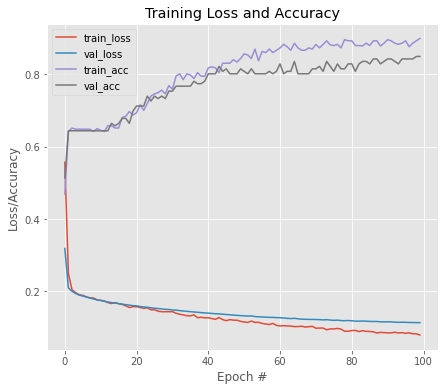

ResourceExhaustedError: OOM when allocating tensor with shape[146,64,128,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2D]

In [22]:
args = get_arguments()
args.batch_size = 32
args.epochs = 100
args.routings = 1
HEIGHT= 128
WIDTH = 128
data = get_rim_one_dl()
get_model_train_test(data,args,high_level_model_name="vgg16",train_half_model=False)



Namespace(augmentation=False, batch_size=32, debug=False, digit=5, epochs=15, lam_recon=0.392, lr=0.0001, lr_decay=1, routings=1, save_dir='./result', shift_fraction=0.1, testing=False, weights=None)
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(32, 128, 128, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (32, 128, 128, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (32, 128, 128, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (32, 64, 64, 64)          0         
_________________________________________________________________
block2_conv1 (Conv2D)        (32, 64, 64, 128)         73856     
_________________________________________________________

C:\Users\gyani-desktop\.conda\envs\lab3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:367: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(



Epoch 00001: val_accuracy improved from -inf to 0.64384, saving model to ./result\weights.h5

Epoch 00002: val_accuracy did not improve from 0.64384

Epoch 00003: val_accuracy improved from 0.64384 to 0.79452, saving model to ./result\weights.h5

Epoch 00004: val_accuracy did not improve from 0.79452

Epoch 00005: val_accuracy improved from 0.79452 to 0.86301, saving model to ./result\weights.h5

Epoch 00006: val_accuracy did not improve from 0.86301

Epoch 00007: val_accuracy improved from 0.86301 to 0.88356, saving model to ./result\weights.h5

Epoch 00008: val_accuracy did not improve from 0.88356

Epoch 00009: val_accuracy did not improve from 0.88356

Epoch 00010: val_accuracy did not improve from 0.88356

Epoch 00011: val_accuracy did not improve from 0.88356

Epoch 00012: val_accuracy improved from 0.88356 to 0.89041, saving model to ./result\weights.h5

Epoch 00013: val_accuracy did not improve from 0.89041

Epoch 00014: val_accuracy did not improve from 0.89041

Epoch 00015: 

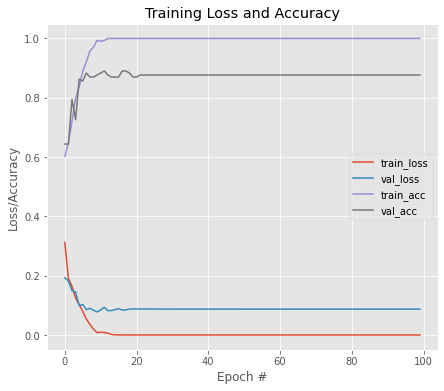

ResourceExhaustedError: OOM when allocating tensor with shape[146,64,128,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2D]

In [23]:
args = get_arguments()
args.batch_size = 32
args.epochs = 100
args.routings = 1
HEIGHT= 128
WIDTH = 128
data = get_rim_one_dl()
get_model_train_test(data,args,high_level_model_name="vgg16",train_half_model=True)

Namespace(augmentation=False, batch_size=32, debug=False, digit=5, epochs=15, lam_recon=0.392, lr=0.0001, lr_decay=1, routings=1, save_dir='./result', shift_fraction=0.1, testing=False, weights=None)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(32, 64, 64, 3)]         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (32, 64, 64, 64)          1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (32, 64, 64, 64)          36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (32, 32, 32, 64)          0         
_________________________________________________________________
block2_conv1 (Conv2D)        (32, 32, 32, 128)         73856     
___________________________________________________________

C:\Users\gyani-desktop\.conda\envs\lab3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:367: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(



Epoch 00001: val_accuracy improved from -inf to 0.64384, saving model to ./result\weights.h5

Epoch 00002: val_accuracy did not improve from 0.64384

Epoch 00003: val_accuracy did not improve from 0.64384

Epoch 00004: val_accuracy did not improve from 0.64384

Epoch 00005: val_accuracy did not improve from 0.64384

Epoch 00006: val_accuracy improved from 0.64384 to 0.71918, saving model to ./result\weights.h5

Epoch 00007: val_accuracy did not improve from 0.71918

Epoch 00008: val_accuracy improved from 0.71918 to 0.80822, saving model to ./result\weights.h5

Epoch 00009: val_accuracy improved from 0.80822 to 0.82192, saving model to ./result\weights.h5

Epoch 00010: val_accuracy did not improve from 0.82192

Epoch 00011: val_accuracy improved from 0.82192 to 0.84932, saving model to ./result\weights.h5

Epoch 00012: val_accuracy improved from 0.84932 to 0.87671, saving model to ./result\weights.h5

Epoch 00013: val_accuracy improved from 0.87671 to 0.89726, saving model to ./result

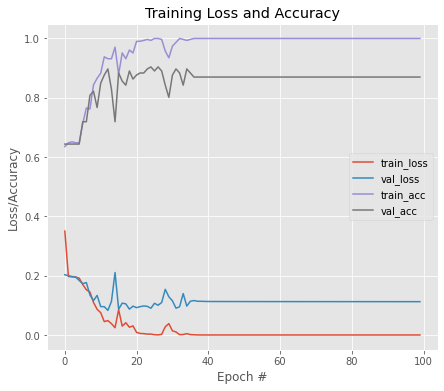

*******Model Performance*************
Test acc: 0.9041095890410958
Precision:0.925531914893617
recall:0.925531914893617
f1:0.925531914893617
AUC:0.8954582651391163
Sensitivity:0.925531914893617
specificity:0.8653846153846154


In [19]:
args = get_arguments()
args.batch_size = 32
args.epochs = 100
args.routings = 1
HEIGHT= 64
WIDTH = 64
data = get_rim_one_dl()
get_model_train_test(data,args,high_level_model_name="vgg19",train_half_model=True)

Namespace(augmentation=False, batch_size=32, debug=False, digit=5, epochs=15, lam_recon=0.392, lr=0.0001, lr_decay=1, routings=1, save_dir='./result', shift_fraction=0.1, testing=False, weights=None)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(32, 64, 64, 3)]    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (32, 70, 70, 3)      0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (32, 32, 32, 64)     9472        conv1_pad[0][0]                  
__________________________________________________________________________________________

C:\Users\gyani-desktop\.conda\envs\lab3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:367: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(



Epoch 00001: val_accuracy improved from -inf to 0.64384, saving model to ./result\weights.h5

Epoch 00002: val_accuracy did not improve from 0.64384

Epoch 00003: val_accuracy did not improve from 0.64384

Epoch 00004: val_accuracy did not improve from 0.64384

Epoch 00005: val_accuracy did not improve from 0.64384

Epoch 00006: val_accuracy did not improve from 0.64384

Epoch 00007: val_accuracy did not improve from 0.64384

Epoch 00008: val_accuracy did not improve from 0.64384

Epoch 00009: val_accuracy did not improve from 0.64384

Epoch 00010: val_accuracy did not improve from 0.64384

Epoch 00011: val_accuracy improved from 0.64384 to 0.65068, saving model to ./result\weights.h5

Epoch 00012: val_accuracy did not improve from 0.65068

Epoch 00013: val_accuracy did not improve from 0.65068

Epoch 00014: val_accuracy did not improve from 0.65068

Epoch 00015: val_accuracy did not improve from 0.65068

Epoch 00016: val_accuracy did not improve from 0.65068

Epoch 00017: val_accurac

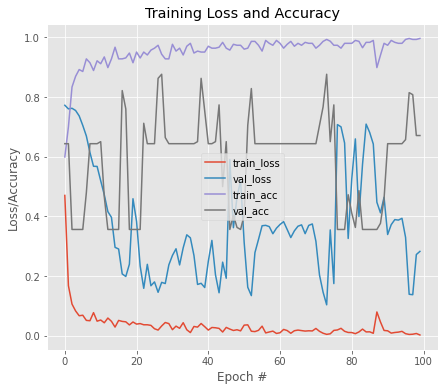

*******Model Performance*************
Test acc: 0.8767123287671232
Precision:0.9523809523809523
recall:0.851063829787234
f1:0.898876404494382
AUC:0.8870703764320786
Sensitivity:0.851063829787234
specificity:0.9230769230769231


In [20]:
args = get_arguments()
args.batch_size = 32
args.epochs = 100
args.routings = 1
HEIGHT= 64
WIDTH = 64
data = get_rim_one_dl()
get_model_train_test(data,args,high_level_model_name="resnet50",train_half_model=True)

Namespace(augmentation=False, batch_size=32, debug=False, digit=5, epochs=15, lam_recon=0.392, lr=0.0001, lr_decay=1, routings=1, save_dir='./result', shift_fraction=0.1, testing=False, weights=None)
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(32, 64, 64, 3)]    0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (32, 70, 70, 3)      0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (32, 32, 32, 64)     9408        zero_padding2d[0][0]             
__________________________________________________________________________________________

C:\Users\gyani-desktop\.conda\envs\lab3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:367: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(



Epoch 00001: val_accuracy improved from -inf to 0.69863, saving model to ./result\weights.h5

Epoch 00002: val_accuracy improved from 0.69863 to 0.70548, saving model to ./result\weights.h5

Epoch 00003: val_accuracy did not improve from 0.70548

Epoch 00004: val_accuracy improved from 0.70548 to 0.73288, saving model to ./result\weights.h5

Epoch 00005: val_accuracy improved from 0.73288 to 0.76027, saving model to ./result\weights.h5

Epoch 00006: val_accuracy improved from 0.76027 to 0.80137, saving model to ./result\weights.h5

Epoch 00007: val_accuracy improved from 0.80137 to 0.84932, saving model to ./result\weights.h5

Epoch 00008: val_accuracy improved from 0.84932 to 0.88356, saving model to ./result\weights.h5

Epoch 00009: val_accuracy improved from 0.88356 to 0.89726, saving model to ./result\weights.h5

Epoch 00010: val_accuracy improved from 0.89726 to 0.90411, saving model to ./result\weights.h5

Epoch 00011: val_accuracy did not improve from 0.90411

Epoch 00012: val_

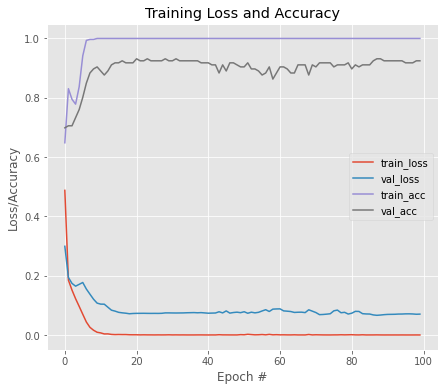

*******Model Performance*************
Test acc: 0.9315068493150684
Precision:0.9375
recall:0.9574468085106383
f1:0.9473684210526315
AUC:0.9210310965630115
Sensitivity:0.9574468085106383
specificity:0.8846153846153846


In [21]:
args = get_arguments()
args.batch_size = 32
args.epochs = 100
args.routings = 1
HEIGHT= 64
WIDTH = 64
data = get_rim_one_dl()
get_model_train_test(data,args,high_level_model_name="densenet121",train_half_model=True)

Namespace(augmentation=False, batch_size=32, debug=False, digit=5, epochs=15, lam_recon=0.392, lr=0.0001, lr_decay=1, routings=1, save_dir='./result', shift_fraction=0.1, testing=False, weights=None)
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(32, 128, 128, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_72 (Conv2D)              (32, 63, 63, 32)     864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_71 (BatchNo (32, 63, 63, 32)     96          conv2d_72[0][0]                  
__________________________________________________________________________________________

C:\Users\gyani-desktop\.conda\envs\lab3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:367: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(



Epoch 00001: val_accuracy improved from -inf to 0.64384, saving model to ./result\weights.h5

Epoch 00002: val_accuracy did not improve from 0.64384

Epoch 00003: val_accuracy did not improve from 0.64384

Epoch 00004: val_accuracy did not improve from 0.64384

Epoch 00005: val_accuracy improved from 0.64384 to 0.72603, saving model to ./result\weights.h5

Epoch 00006: val_accuracy improved from 0.72603 to 0.78767, saving model to ./result\weights.h5

Epoch 00007: val_accuracy improved from 0.78767 to 0.80822, saving model to ./result\weights.h5

Epoch 00008: val_accuracy improved from 0.80822 to 0.81507, saving model to ./result\weights.h5

Epoch 00009: val_accuracy did not improve from 0.81507

Epoch 00010: val_accuracy improved from 0.81507 to 0.82192, saving model to ./result\weights.h5

Epoch 00011: val_accuracy did not improve from 0.82192

Epoch 00012: val_accuracy improved from 0.82192 to 0.82877, saving model to ./result\weights.h5

Epoch 00013: val_accuracy did not improve f

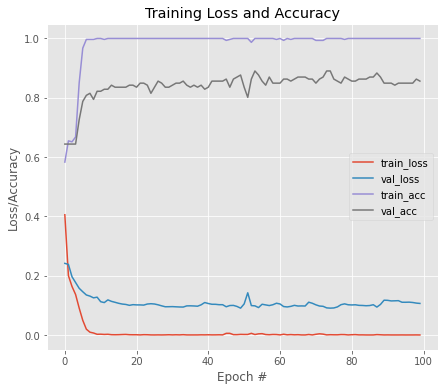

*******Model Performance*************
Test acc: 0.8904109589041096
Precision:0.875
recall:0.9680851063829787
f1:0.9191919191919191
AUC:0.8590425531914894
Sensitivity:0.9680851063829787
specificity:0.75


In [23]:
args = get_arguments()
args.batch_size = 32
args.epochs = 100
args.routings = 1
HEIGHT= 128
WIDTH = 128
data = get_rim_one_dl()
get_model_train_test(data,args,high_level_model_name="InceptionV3",train_half_model=True)

# RIMONE V2

Namespace(augmentation=False, batch_size=32, debug=False, digit=5, epochs=15, lam_recon=0.392, lr=0.0001, lr_decay=1, routings=1, save_dir='./result', shift_fraction=0.1, testing=False, weights=None)
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(32, 128, 128, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (32, 128, 128, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (32, 128, 128, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (32, 64, 64, 64)          0         
_________________________________________________________________
block2_conv1 (Conv2D)        (32, 64, 64, 128)         73856     
_________________________________________________________

C:\Users\gyani-desktop\.conda\envs\lab3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:367: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(



Epoch 00001: val_accuracy improved from -inf to 0.56044, saving model to ./result\weights.h5

Epoch 00002: val_accuracy improved from 0.56044 to 0.64835, saving model to ./result\weights.h5

Epoch 00003: val_accuracy improved from 0.64835 to 0.72527, saving model to ./result\weights.h5

Epoch 00004: val_accuracy improved from 0.72527 to 0.75824, saving model to ./result\weights.h5

Epoch 00005: val_accuracy improved from 0.75824 to 0.80220, saving model to ./result\weights.h5

Epoch 00006: val_accuracy improved from 0.80220 to 0.85714, saving model to ./result\weights.h5

Epoch 00007: val_accuracy did not improve from 0.85714

Epoch 00008: val_accuracy did not improve from 0.85714

Epoch 00009: val_accuracy improved from 0.85714 to 0.86813, saving model to ./result\weights.h5

Epoch 00010: val_accuracy improved from 0.86813 to 0.87912, saving model to ./result\weights.h5

Epoch 00011: val_accuracy did not improve from 0.87912

Epoch 00012: val_accuracy did not improve from 0.87912

Ep

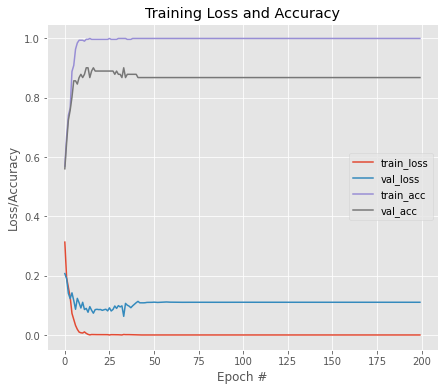

ResourceExhaustedError: OOM when allocating tensor with shape[91,64,128,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2D]

In [24]:
args = get_arguments()
args.batch_size = 32
args.epochs = 200
args.routings = 1
HEIGHT= 128
WIDTH = 128
data = get_rim_one_db_r2()
get_model_train_test(data,args,high_level_model_name="vgg16",train_half_model=True)

Namespace(augmentation=False, batch_size=32, debug=False, digit=5, epochs=15, lam_recon=0.392, lr=0.0001, lr_decay=1, routings=1, save_dir='./result', shift_fraction=0.1, testing=False, weights=None)
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(32, 128, 128, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (32, 128, 128, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (32, 128, 128, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (32, 64, 64, 64)          0         
_________________________________________________________________
block2_conv1 (Conv2D)        (32, 64, 64, 128)         73856     
_________________________________________________________

C:\Users\gyani-desktop\.conda\envs\lab3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:367: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(



Epoch 00001: val_accuracy improved from -inf to 0.56044, saving model to ./result\weights.h5

Epoch 00002: val_accuracy did not improve from 0.56044

Epoch 00003: val_accuracy improved from 0.56044 to 0.72527, saving model to ./result\weights.h5

Epoch 00004: val_accuracy did not improve from 0.72527

Epoch 00005: val_accuracy improved from 0.72527 to 0.75824, saving model to ./result\weights.h5

Epoch 00006: val_accuracy improved from 0.75824 to 0.83516, saving model to ./result\weights.h5

Epoch 00007: val_accuracy did not improve from 0.83516

Epoch 00008: val_accuracy improved from 0.83516 to 0.90110, saving model to ./result\weights.h5

Epoch 00009: val_accuracy did not improve from 0.90110

Epoch 00010: val_accuracy did not improve from 0.90110

Epoch 00011: val_accuracy did not improve from 0.90110

Epoch 00012: val_accuracy did not improve from 0.90110

Epoch 00013: val_accuracy did not improve from 0.90110

Epoch 00014: val_accuracy did not improve from 0.90110

Epoch 00015: 

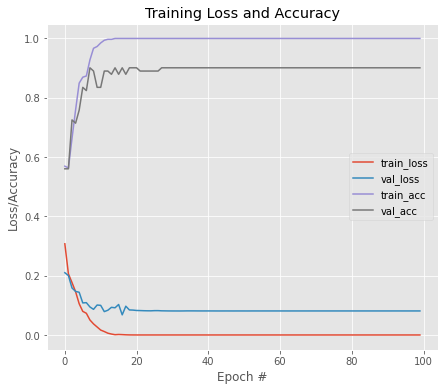

ResourceExhaustedError: OOM when allocating tensor with shape[91,64,128,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2D]

In [25]:
args = get_arguments()
args.batch_size = 32
args.epochs = 100
args.routings = 1
HEIGHT= 128
WIDTH = 128
data = get_rim_one_db_r2()
get_model_train_test(data,args,high_level_model_name="vgg19",train_half_model=True)

Namespace(augmentation=False, batch_size=32, debug=False, digit=5, epochs=15, lam_recon=0.392, lr=0.0001, lr_decay=1, routings=1, save_dir='./result', shift_fraction=0.1, testing=False, weights=None)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(32, 128, 128, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (32, 134, 134, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (32, 64, 64, 64)     9472        conv1_pad[0][0]                  
____________________________________________________________________________________________

C:\Users\gyani-desktop\.conda\envs\lab3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:367: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(



Epoch 00001: val_accuracy improved from -inf to 0.54945, saving model to ./result\weights.h5

Epoch 00002: val_accuracy did not improve from 0.54945

Epoch 00003: val_accuracy did not improve from 0.54945

Epoch 00004: val_accuracy improved from 0.54945 to 0.56044, saving model to ./result\weights.h5

Epoch 00005: val_accuracy did not improve from 0.56044

Epoch 00006: val_accuracy did not improve from 0.56044

Epoch 00007: val_accuracy did not improve from 0.56044

Epoch 00008: val_accuracy did not improve from 0.56044

Epoch 00009: val_accuracy did not improve from 0.56044

Epoch 00010: val_accuracy did not improve from 0.56044

Epoch 00011: val_accuracy did not improve from 0.56044

Epoch 00012: val_accuracy did not improve from 0.56044

Epoch 00013: val_accuracy did not improve from 0.56044

Epoch 00014: val_accuracy did not improve from 0.56044

Epoch 00015: val_accuracy did not improve from 0.56044

Epoch 00016: val_accuracy did not improve from 0.56044

Epoch 00017: val_accurac

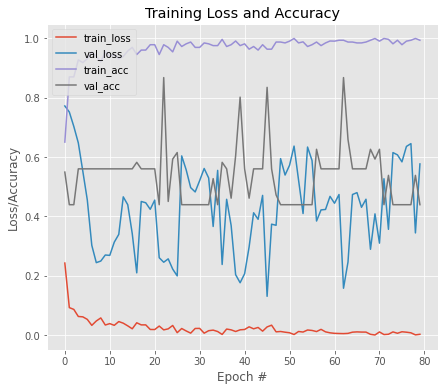

*******Model Performance*************
Test acc: 0.8681318681318682
Precision:0.8305084745762712
recall:0.9607843137254902
f1:0.890909090909091
AUC:0.8553921568627452
Sensitivity:0.9607843137254902
specificity:0.75


In [23]:
args = get_arguments()
args.batch_size = 32
args.epochs = 80
args.routings = 1
HEIGHT= 128
WIDTH = 128
data = get_rim_one_db_r2()
get_model_train_test(data,args,high_level_model_name="resnet50",train_half_model=True)

Namespace(augmentation=False, batch_size=32, debug=False, digit=5, epochs=15, lam_recon=0.392, lr=0.0001, lr_decay=1, routings=1, save_dir='./result', shift_fraction=0.1, testing=False, weights=None)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(32, 128, 128, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (32, 134, 134, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (32, 64, 64, 64)     9408        zero_padding2d[0][0]             
__________________________________________________________________________________________

C:\Users\gyani-desktop\.conda\envs\lab3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:367: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(



Epoch 00001: val_accuracy improved from -inf to 0.62637, saving model to ./result\weights.h5

Epoch 00002: val_accuracy did not improve from 0.62637

Epoch 00003: val_accuracy improved from 0.62637 to 0.79121, saving model to ./result\weights.h5

Epoch 00004: val_accuracy improved from 0.79121 to 0.85714, saving model to ./result\weights.h5

Epoch 00005: val_accuracy did not improve from 0.85714

Epoch 00006: val_accuracy did not improve from 0.85714

Epoch 00007: val_accuracy did not improve from 0.85714

Epoch 00008: val_accuracy improved from 0.85714 to 0.87912, saving model to ./result\weights.h5

Epoch 00009: val_accuracy did not improve from 0.87912

Epoch 00010: val_accuracy did not improve from 0.87912

Epoch 00011: val_accuracy improved from 0.87912 to 0.89011, saving model to ./result\weights.h5

Epoch 00012: val_accuracy did not improve from 0.89011

Epoch 00013: val_accuracy improved from 0.89011 to 0.90110, saving model to ./result\weights.h5

Epoch 00014: val_accuracy di

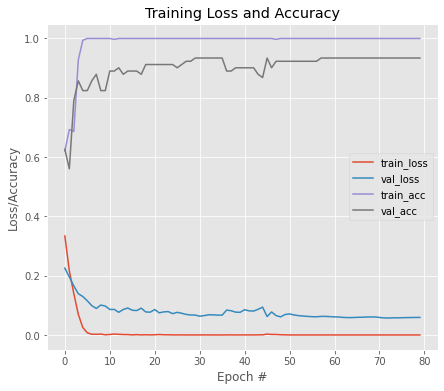

*******Model Performance*************
Test acc: 0.9340659340659341
Precision:0.8947368421052632
recall:1.0
f1:0.9444444444444444
AUC:0.9249999999999999
Sensitivity:1.0
specificity:0.85


In [24]:
args = get_arguments()
args.batch_size = 32
args.epochs = 80
args.routings = 1
HEIGHT= 128
WIDTH = 128
data = get_rim_one_db_r2()
get_model_train_test(data,args,high_level_model_name="densenet121",train_half_model=True)

Namespace(augmentation=False, batch_size=32, debug=False, digit=5, epochs=15, lam_recon=0.392, lr=0.0001, lr_decay=1, routings=1, save_dir='./result', shift_fraction=0.1, testing=False, weights=None)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(32, 64, 64, 3)]    0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (32, 70, 70, 3)      0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (32, 32, 32, 64)     9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________

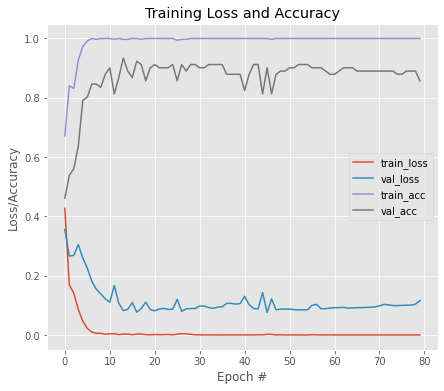

*******Model Performance*************
Test acc: 0.9340659340659341
Precision:0.8947368421052632
recall:1.0
f1:0.9444444444444444
AUC:0.9249999999999999
Sensitivity:1.0
specificity:0.85


In [22]:
args = get_arguments()
args.batch_size = 32
args.epochs = 80
args.routings = 1
HEIGHT= 64
WIDTH = 64
data = get_rim_one_db_r2()
get_model_train_test(data,args,high_level_model_name="densenet169",train_half_model=True)

Namespace(augmentation=False, batch_size=32, debug=False, digit=5, epochs=15, lam_recon=0.392, lr=0.0001, lr_decay=1, routings=1, save_dir='./result', shift_fraction=0.1, testing=False, weights=None)
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(32, 128, 128, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (32, 63, 63, 32)     864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (32, 63, 63, 32)     96          conv2d[0][0]                     
__________________________________________________________________________________________

C:\Users\gyani-desktop\.conda\envs\lab3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:367: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(



Epoch 00001: val_accuracy improved from -inf to 0.57143, saving model to ./result\weights.h5

Epoch 00002: val_accuracy did not improve from 0.57143

Epoch 00003: val_accuracy improved from 0.57143 to 0.61538, saving model to ./result\weights.h5

Epoch 00004: val_accuracy improved from 0.61538 to 0.70330, saving model to ./result\weights.h5

Epoch 00005: val_accuracy did not improve from 0.70330

Epoch 00006: val_accuracy improved from 0.70330 to 0.79121, saving model to ./result\weights.h5

Epoch 00007: val_accuracy improved from 0.79121 to 0.81319, saving model to ./result\weights.h5

Epoch 00008: val_accuracy did not improve from 0.81319

Epoch 00009: val_accuracy did not improve from 0.81319

Epoch 00010: val_accuracy did not improve from 0.81319

Epoch 00011: val_accuracy improved from 0.81319 to 0.82418, saving model to ./result\weights.h5

Epoch 00012: val_accuracy did not improve from 0.82418

Epoch 00013: val_accuracy did not improve from 0.82418

Epoch 00014: val_accuracy im

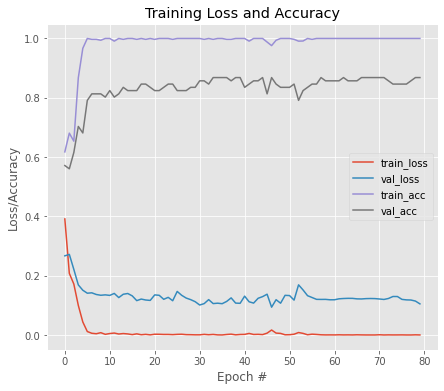

*******Model Performance*************
Test acc: 0.8681318681318682
Precision:0.8095238095238095
recall:1.0
f1:0.8947368421052632
AUC:0.85
Sensitivity:1.0
specificity:0.7


In [23]:
args = get_arguments()
args.batch_size = 32
args.epochs = 80
args.routings = 1
HEIGHT= 128
WIDTH = 128
data = get_rim_one_db_r2()
get_model_train_test(data,args,high_level_model_name="InceptionV3",train_half_model=True)

Namespace(augmentation=False, batch_size=32, debug=False, digit=5, epochs=15, lam_recon=0.392, lr=0.0001, lr_decay=1, routings=1, save_dir='./result', shift_fraction=0.1, testing=False, weights=None)
17227776/17225924 [==============================] - 3s 0us/step
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(32, 128, 128, 3)]       0         
_________________________________________________________________
conv1 (Conv2D)               (32, 64, 64, 32)          864       
_________________________________________________________________
conv1_bn (BatchNormalization (32, 64, 64, 32)          128       
_________________________________________________________________
conv1_relu (ReLU)            (32, 64, 64, 32)          0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (32, 64, 64, 32)          288

C:\Users\gyani-desktop\.conda\envs\lab3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:367: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(



Epoch 00001: val_accuracy improved from -inf to 0.58242, saving model to ./result\weights.h5

Epoch 00002: val_accuracy did not improve from 0.58242

Epoch 00003: val_accuracy improved from 0.58242 to 0.70330, saving model to ./result\weights.h5

Epoch 00004: val_accuracy improved from 0.70330 to 0.75824, saving model to ./result\weights.h5

Epoch 00005: val_accuracy did not improve from 0.75824

Epoch 00006: val_accuracy did not improve from 0.75824

Epoch 00007: val_accuracy did not improve from 0.75824

Epoch 00008: val_accuracy did not improve from 0.75824

Epoch 00009: val_accuracy improved from 0.75824 to 0.76923, saving model to ./result\weights.h5

Epoch 00010: val_accuracy improved from 0.76923 to 0.79121, saving model to ./result\weights.h5

Epoch 00011: val_accuracy improved from 0.79121 to 0.80220, saving model to ./result\weights.h5

Epoch 00012: val_accuracy improved from 0.80220 to 0.82418, saving model to ./result\weights.h5

Epoch 00013: val_accuracy improved from 0.8

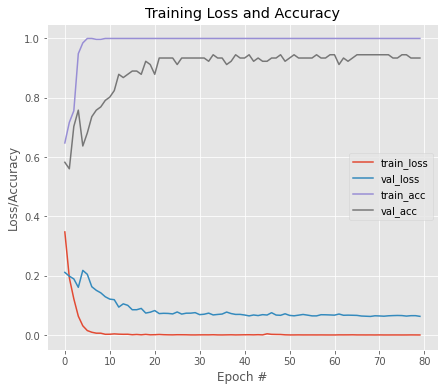

*******Model Performance*************
Test acc: 0.945054945054945
Precision:0.9107142857142857
recall:1.0
f1:0.9532710280373832
AUC:0.9375
Sensitivity:1.0
specificity:0.875


In [26]:
args = get_arguments()
args.batch_size = 32
args.epochs = 80
args.routings = 1
HEIGHT= 128
WIDTH = 128
data = get_rim_one_db_r2()
get_model_train_test(data,args,high_level_model_name="MobileNet",train_half_model=True)

# ACRIMA

Namespace(augmentation=False, batch_size=32, debug=False, digit=5, epochs=15, lam_recon=0.392, lr=0.0001, lr_decay=1, routings=1, save_dir='./result', shift_fraction=0.1, testing=False, weights=None)
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(32, 128, 128, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (32, 128, 128, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (32, 128, 128, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (32, 64, 64, 64)          0         
_________________________________________________________________
block2_conv1 (Conv2D)        (32, 64, 64, 128)         73856     
_________________________________________________________

C:\Users\gyani-desktop\.conda\envs\lab3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:367: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(



Epoch 00001: val_accuracy improved from -inf to 0.58865, saving model to ./result\weights.h5

Epoch 00002: val_accuracy improved from 0.58865 to 0.78014, saving model to ./result\weights.h5

Epoch 00003: val_accuracy improved from 0.78014 to 0.90071, saving model to ./result\weights.h5

Epoch 00004: val_accuracy improved from 0.90071 to 0.90780, saving model to ./result\weights.h5

Epoch 00005: val_accuracy did not improve from 0.90780

Epoch 00006: val_accuracy improved from 0.90780 to 0.92199, saving model to ./result\weights.h5

Epoch 00007: val_accuracy improved from 0.92199 to 0.93617, saving model to ./result\weights.h5

Epoch 00008: val_accuracy did not improve from 0.93617

Epoch 00009: val_accuracy did not improve from 0.93617

Epoch 00010: val_accuracy improved from 0.93617 to 0.94326, saving model to ./result\weights.h5

Epoch 00011: val_accuracy did not improve from 0.94326

Epoch 00012: val_accuracy did not improve from 0.94326

Epoch 00013: val_accuracy did not improve f

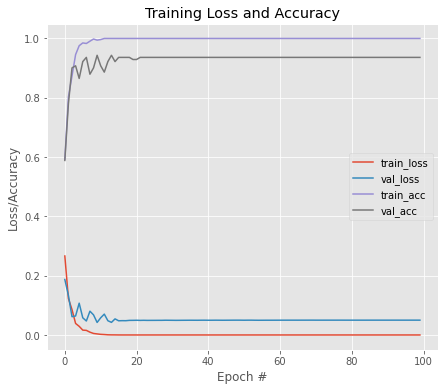

ResourceExhaustedError: OOM when allocating tensor with shape[141,64,128,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2D]

In [27]:
args = get_arguments()
args.batch_size = 32
args.epochs = 100
args.routings = 1
HEIGHT= 128
WIDTH = 128
data = get_acrima_dataset()
get_model_train_test(data,args,high_level_model_name="vgg16",train_half_model=True)

Namespace(augmentation=False, batch_size=32, debug=False, digit=5, epochs=15, lam_recon=0.392, lr=0.0001, lr_decay=1, routings=1, save_dir='./result', shift_fraction=0.1, testing=False, weights=None)
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(32, 128, 128, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (32, 128, 128, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (32, 128, 128, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (32, 64, 64, 64)          0         
_________________________________________________________________
block2_conv1 (Conv2D)        (32, 64, 64, 128)         73856     
_________________________________________________________

C:\Users\gyani-desktop\.conda\envs\lab3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:367: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(



Epoch 00001: val_accuracy improved from -inf to 0.80142, saving model to ./result\weights.h5

Epoch 00002: val_accuracy improved from 0.80142 to 0.87943, saving model to ./result\weights.h5

Epoch 00003: val_accuracy did not improve from 0.87943

Epoch 00004: val_accuracy did not improve from 0.87943

Epoch 00005: val_accuracy improved from 0.87943 to 0.88652, saving model to ./result\weights.h5

Epoch 00006: val_accuracy improved from 0.88652 to 0.92199, saving model to ./result\weights.h5

Epoch 00007: val_accuracy did not improve from 0.92199

Epoch 00008: val_accuracy did not improve from 0.92199

Epoch 00009: val_accuracy improved from 0.92199 to 0.93617, saving model to ./result\weights.h5

Epoch 00010: val_accuracy did not improve from 0.93617

Epoch 00011: val_accuracy improved from 0.93617 to 0.94326, saving model to ./result\weights.h5

Epoch 00012: val_accuracy did not improve from 0.94326

Epoch 00013: val_accuracy did not improve from 0.94326

Epoch 00014: val_accuracy di

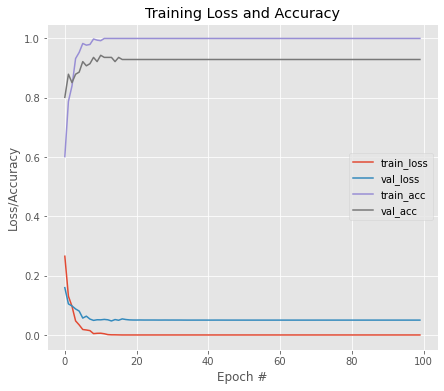

ResourceExhaustedError: OOM when allocating tensor with shape[141,64,128,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2D]

In [28]:
args = get_arguments()
args.batch_size = 32
args.epochs = 100
args.routings = 1
HEIGHT= 128
WIDTH = 128
data = get_acrima_dataset()
get_model_train_test(data,args,high_level_model_name="vgg19",train_half_model=True)

Namespace(augmentation=False, batch_size=32, debug=False, digit=5, epochs=15, lam_recon=0.392, lr=0.0001, lr_decay=1, routings=1, save_dir='./result', shift_fraction=0.1, testing=False, weights=None)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(32, 128, 128, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (32, 134, 134, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (32, 64, 64, 64)     9472        conv1_pad[0][0]                  
____________________________________________________________________________________________

C:\Users\gyani-desktop\.conda\envs\lab3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:367: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(



Epoch 00001: val_accuracy improved from -inf to 0.41135, saving model to ./result\weights.h5

Epoch 00002: val_accuracy improved from 0.41135 to 0.63830, saving model to ./result\weights.h5

Epoch 00003: val_accuracy did not improve from 0.63830

Epoch 00004: val_accuracy did not improve from 0.63830

Epoch 00005: val_accuracy did not improve from 0.63830

Epoch 00006: val_accuracy did not improve from 0.63830

Epoch 00007: val_accuracy did not improve from 0.63830

Epoch 00008: val_accuracy did not improve from 0.63830

Epoch 00009: val_accuracy did not improve from 0.63830

Epoch 00010: val_accuracy did not improve from 0.63830

Epoch 00011: val_accuracy did not improve from 0.63830

Epoch 00012: val_accuracy did not improve from 0.63830

Epoch 00013: val_accuracy did not improve from 0.63830

Epoch 00014: val_accuracy did not improve from 0.63830

Epoch 00015: val_accuracy did not improve from 0.63830

Epoch 00016: val_accuracy improved from 0.63830 to 0.68794, saving model to ./re

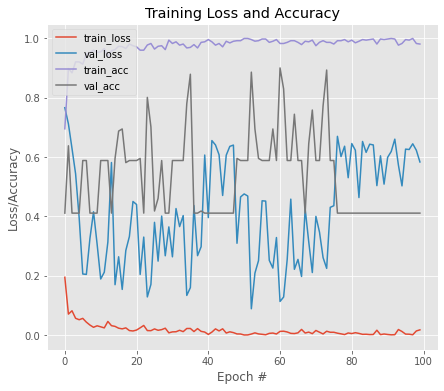

*******Model Performance*************
Test acc: 0.900709219858156
Precision:0.8666666666666667
recall:0.896551724137931
f1:0.8813559322033899
AUC:0.9000830909846282
Sensitivity:0.896551724137931
specificity:0.9036144578313253


In [21]:
args = get_arguments()
args.batch_size = 32
args.epochs = 100
args.routings = 1
HEIGHT= 128
WIDTH = 128
data = get_acrima_dataset()
get_model_train_test(data,args,high_level_model_name="resnet50",train_half_model=True)

Namespace(augmentation=False, batch_size=32, debug=False, digit=5, epochs=15, lam_recon=0.392, lr=0.0001, lr_decay=1, routings=1, save_dir='./result', shift_fraction=0.1, testing=False, weights=None)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(32, 128, 128, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (32, 134, 134, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (32, 64, 64, 64)     9408        zero_padding2d[0][0]             
__________________________________________________________________________________________

C:\Users\gyani-desktop\.conda\envs\lab3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:367: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(



Epoch 00001: val_accuracy improved from -inf to 0.58865, saving model to ./result\weights.h5

Epoch 00002: val_accuracy improved from 0.58865 to 0.79433, saving model to ./result\weights.h5

Epoch 00003: val_accuracy improved from 0.79433 to 0.83688, saving model to ./result\weights.h5

Epoch 00004: val_accuracy improved from 0.83688 to 0.90780, saving model to ./result\weights.h5

Epoch 00005: val_accuracy improved from 0.90780 to 0.91489, saving model to ./result\weights.h5

Epoch 00006: val_accuracy improved from 0.91489 to 0.92199, saving model to ./result\weights.h5

Epoch 00007: val_accuracy improved from 0.92199 to 0.93617, saving model to ./result\weights.h5

Epoch 00008: val_accuracy improved from 0.93617 to 0.94326, saving model to ./result\weights.h5

Epoch 00009: val_accuracy did not improve from 0.94326

Epoch 00010: val_accuracy improved from 0.94326 to 0.95035, saving model to ./result\weights.h5

Epoch 00011: val_accuracy did not improve from 0.95035

Epoch 00012: val_

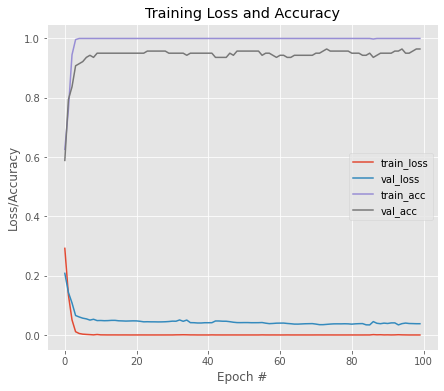

*******Model Performance*************
Test acc: 0.9645390070921985
Precision:0.9491525423728814
recall:0.9655172413793104
f1:0.9572649572649573
AUC:0.9646863315330287
Sensitivity:0.9655172413793104
specificity:0.963855421686747


In [22]:
args = get_arguments()
args.batch_size = 32
args.epochs = 100
args.routings = 1
HEIGHT= 128
WIDTH = 128
data = get_acrima_dataset()
get_model_train_test(data,args,high_level_model_name="densenet121",train_half_model=True)

Namespace(augmentation=False, batch_size=32, debug=False, digit=5, epochs=15, lam_recon=0.392, lr=0.0001, lr_decay=1, routings=1, save_dir='./result', shift_fraction=0.1, testing=False, weights=None)
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(32, 64, 64, 3)]    0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (32, 70, 70, 3)      0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (32, 32, 32, 64)     9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________

C:\Users\gyani-desktop\.conda\envs\lab3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:367: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(



Epoch 00001: val_accuracy improved from -inf to 0.75887, saving model to ./result\weights.h5

Epoch 00002: val_accuracy did not improve from 0.75887

Epoch 00003: val_accuracy did not improve from 0.75887

Epoch 00004: val_accuracy improved from 0.75887 to 0.80851, saving model to ./result\weights.h5

Epoch 00005: val_accuracy improved from 0.80851 to 0.87234, saving model to ./result\weights.h5

Epoch 00006: val_accuracy did not improve from 0.87234

Epoch 00007: val_accuracy did not improve from 0.87234

Epoch 00008: val_accuracy did not improve from 0.87234

Epoch 00009: val_accuracy improved from 0.87234 to 0.87943, saving model to ./result\weights.h5

Epoch 00010: val_accuracy improved from 0.87943 to 0.90780, saving model to ./result\weights.h5

Epoch 00011: val_accuracy did not improve from 0.90780

Epoch 00012: val_accuracy improved from 0.90780 to 0.92199, saving model to ./result\weights.h5

Epoch 00013: val_accuracy did not improve from 0.92199

Epoch 00014: val_accuracy im

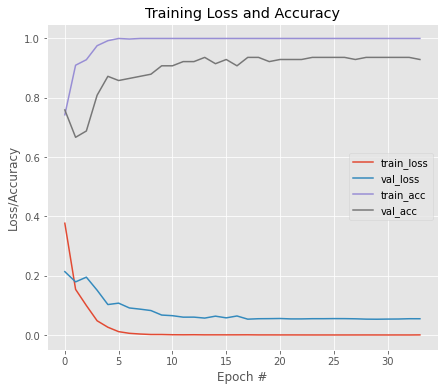

*******Model Performance*************
Test acc: 0.9361702127659575
Precision:0.9152542372881356
recall:0.9310344827586207
f1:0.923076923076923
AUC:0.9353967594515994
Sensitivity:0.9310344827586207
specificity:0.9397590361445783


In [24]:
args = get_arguments()
args.batch_size = 32
args.epochs = 100
args.routings = 1
HEIGHT= 64
WIDTH = 64
data = get_acrima_dataset()
get_model_train_test(data,args,high_level_model_name="densenet121",train_half_model=True)

Namespace(augmentation=False, batch_size=32, debug=False, digit=5, epochs=15, lam_recon=0.392, lr=0.0001, lr_decay=1, routings=1, save_dir='./result', shift_fraction=0.1, testing=False, weights=None)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(32, 64, 64, 3)]    0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (32, 70, 70, 3)      0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (32, 32, 32, 64)     9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________

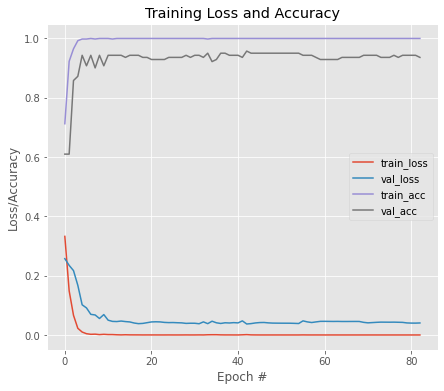

*******Model Performance*************
Test acc: 0.9574468085106383
Precision:0.9333333333333333
recall:0.9655172413793104
f1:0.9491525423728815
AUC:0.9586622351474865
Sensitivity:0.9655172413793104
specificity:0.9518072289156626


In [20]:
args = get_arguments()
args.batch_size = 32
args.epochs = 100
args.routings = 1
HEIGHT= 64
WIDTH = 64
data = get_acrima_dataset()
get_model_train_test(data,args,high_level_model_name="densenet169",train_half_model=True)

Namespace(augmentation=False, batch_size=32, debug=False, digit=5, epochs=15, lam_recon=0.392, lr=0.0001, lr_decay=1, routings=1, save_dir='./result', shift_fraction=0.1, testing=False, weights=None)
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(32, 128, 128, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (32, 63, 63, 32)     864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (32, 63, 63, 32)     96          conv2d[0][0]                     
__________________________________________________________________________________________

C:\Users\gyani-desktop\.conda\envs\lab3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:367: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(



Epoch 00001: val_accuracy improved from -inf to 0.70922, saving model to ./result\weights.h5

Epoch 00002: val_accuracy did not improve from 0.70922

Epoch 00003: val_accuracy improved from 0.70922 to 0.80851, saving model to ./result\weights.h5

Epoch 00004: val_accuracy did not improve from 0.80851

Epoch 00005: val_accuracy did not improve from 0.80851

Epoch 00006: val_accuracy improved from 0.80851 to 0.82270, saving model to ./result\weights.h5

Epoch 00007: val_accuracy did not improve from 0.82270

Epoch 00008: val_accuracy improved from 0.82270 to 0.82979, saving model to ./result\weights.h5

Epoch 00009: val_accuracy did not improve from 0.82979

Epoch 00010: val_accuracy did not improve from 0.82979

Epoch 00011: val_accuracy improved from 0.82979 to 0.85816, saving model to ./result\weights.h5

Epoch 00012: val_accuracy did not improve from 0.85816

Epoch 00013: val_accuracy did not improve from 0.85816

Epoch 00014: val_accuracy did not improve from 0.85816

Epoch 00015: 

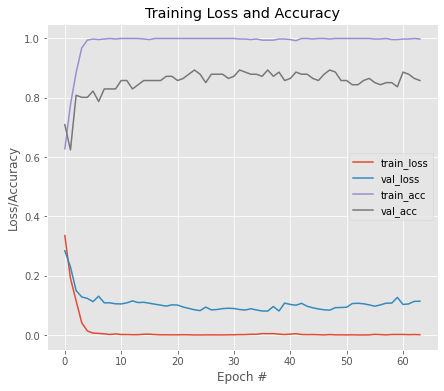

*******Model Performance*************
Test acc: 0.8936170212765957
Precision:0.864406779661017
recall:0.8793103448275862
f1:0.8717948717948718
AUC:0.8914624013294559
Sensitivity:0.8793103448275862
specificity:0.9036144578313253


In [21]:
args = get_arguments()
args.batch_size = 32
args.epochs = 100
args.routings = 1
HEIGHT= 128
WIDTH = 128
data = get_acrima_dataset()
get_model_train_test(data,args,high_level_model_name="InceptionV3",train_half_model=True)

Namespace(augmentation=False, batch_size=32, debug=False, digit=5, epochs=15, lam_recon=0.392, lr=0.0001, lr_decay=1, routings=1, save_dir='./result', shift_fraction=0.1, testing=False, weights=None)
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(32, 128, 128, 3)]       0         
_________________________________________________________________
conv1 (Conv2D)               (32, 64, 64, 32)          864       
_________________________________________________________________
conv1_bn (BatchNormalization (32, 64, 64, 32)          128       
_________________________________________________________________
conv1_relu (ReLU)            (32, 64, 64, 32)          0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (32, 64, 64, 32)          288       
_________________________________________________________

C:\Users\gyani-desktop\.conda\envs\lab3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:367: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(



Epoch 00001: val_accuracy improved from -inf to 0.58865, saving model to ./result\weights.h5

Epoch 00002: val_accuracy improved from 0.58865 to 0.59574, saving model to ./result\weights.h5

Epoch 00003: val_accuracy improved from 0.59574 to 0.70922, saving model to ./result\weights.h5

Epoch 00004: val_accuracy improved from 0.70922 to 0.80142, saving model to ./result\weights.h5

Epoch 00005: val_accuracy did not improve from 0.80142

Epoch 00006: val_accuracy improved from 0.80142 to 0.86525, saving model to ./result\weights.h5

Epoch 00007: val_accuracy did not improve from 0.86525

Epoch 00008: val_accuracy did not improve from 0.86525

Epoch 00009: val_accuracy improved from 0.86525 to 0.89362, saving model to ./result\weights.h5

Epoch 00010: val_accuracy improved from 0.89362 to 0.90071, saving model to ./result\weights.h5

Epoch 00011: val_accuracy improved from 0.90071 to 0.90780, saving model to ./result\weights.h5

Epoch 00012: val_accuracy did not improve from 0.90780

Ep

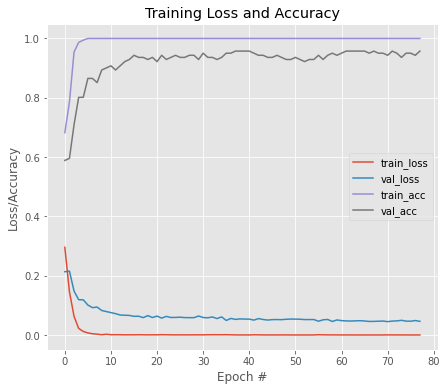

*******Model Performance*************
Test acc: 0.9574468085106383
Precision:0.9482758620689655
recall:0.9482758620689655
f1:0.9482758620689655
AUC:0.9560656418778563
Sensitivity:0.9482758620689655
specificity:0.963855421686747


In [22]:
args = get_arguments()
args.batch_size = 32
args.epochs = 100
args.routings = 1
HEIGHT= 128
WIDTH = 128
data = get_acrima_dataset()
get_model_train_test(data,args,high_level_model_name="MobileNet",train_half_model=True)